In [1]:
import pandas as pd
import numpy as np
from Bio import SeqIO
import os
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from Bio import Phylo
from Bio.SeqRecord import SeqRecord
from Bio.Seq import Seq

In [2]:
def count_ec_cats(eggnog_output_sel):
    #Number of secreted proteins that fit in each COG category
    cog_counts_dict = dict()
    for cogcat in eggnog_output_sel['EC'].fillna('None'):
        #if cogcat != 'None' and len(cogcat) > 0:
        #    list_of_cats = [char for char in cogcat]
        #else:
        #    list_of_cats = [cogcat]
        list_of_cats = cogcat.split(',')
        
        for cat in list_of_cats:
            if cat in cog_counts_dict.keys():
                cog_counts_dict[cat] = cog_counts_dict[cat] + 1
            else:
                cog_counts_dict[cat] = 1
    return(cog_counts_dict)

def count_cazyme_cats(eggnog_output_sel):
    #Number of secreted proteins that fit in each cazyme category
    cazyme_counts_dict = dict()
    for cazymecat in eggnog_output_sel['CAZy'].fillna('None'):
        list_of_cats = cazymecat.split(',')
        for cat in list_of_cats:
            if cat in cazyme_counts_dict.keys():
                cazyme_counts_dict[cat] = cazyme_counts_dict[cat] + 1
            else:
                cazyme_counts_dict[cat] = 1

    return(cazyme_counts_dict)

#Break down by phyla

def sum_lists_itemwise(list1,list2):
    list3 = []
    ind = 0
    for item in list1:
        list3.append(item + list2[ind])
        ind = ind + 1
    return(list3)

def ec_orfs_to_text(EC_query):
    ec_orfs_list = []
    for name, group in eggnog_output_filtered.groupby('EC'):
        if EC_query in name.split(','):
            ec_orfs_list = ec_orfs_list + group['query_name'].tolist()
    with open('ipynb_out/EC_orfids_v5/' + EC_query + '.txt', 'w') as filehandle:
        for listitem in ec_orfs_list:
            filehandle.write('%s\n' % listitem)

In [3]:
eggnog_output = pd.read_csv('/home/ec2-user/20221005_metasecretome_notebooks/20221012_MM_9ny4543y.emapper.annotations.tsv',
           skiprows=4, sep='\t', index_col=False, skipfooter=3).rename(columns={'#query':'query'})
eggnog_output['genome_id'] = ['_'.join(orfid.split('_')[:2]) for orfid in eggnog_output['query']]

/home/ec2-user/bin/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support skipfooter; you can avoid this warning by specifying engine='python'.
  


In [5]:
os.mkdir('suppl_tables')

In [6]:
eggnog_output.to_csv('suppl_tables/Supplementary_table_S1.tsv', sep='\t', header=True, index=False)

In [7]:
HGM_species = pd.read_csv('/home/ec2-user/20190504_HGM_prodigal/IGG_species_info_23790.tsv', sep='\t')
HGM_genomes = pd.read_csv('/home/ec2-user/20190504_HGM_prodigal/IGG_genome_info_206581.tsv', sep='\t')


/home/ec2-user/bin/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3049: DtypeWarning: Columns (0,4) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [8]:
#General top COGs in all secreted proteins from representative MAGs

COG2descriptor = {"J": "translation, including ribosome structure and biogenesis",
 "L": "replication, recombination and repair",
 "K": "transcription",
 "O": "molecular chaperones and related functions",
 "M": "cell wall structure and biogenesis and outer membrane",
 "N": "secretion, motility and chemotaxis",
 "T": "signal transduction",
 "P": "inorganic ion transport and metabolism",
 "C": "energy production and conversion",
 "G": "carbohydrate metabolism and transport",
 "E": "amino acid metabolism and transport",
 "F": "nucleotide metabolism and transport",
 "H": "coenzyme metabolism",
 "I": "lipid metabolism",
 "D": "cell division and chromosome partitioning",
 "R": "general functional prediction only",
 "S": "no functional prediction",
 "None": "None"}

phycoldict = {'Firmicutes': 'red', 
 'Actinobacteria': 'green', 
 'Bacteroidetes': 'blue', 
 'Proteobacteria': 'orange',
       'Verrucomicrobia': 'lightgreen', 
 'Desulfobacteraeota_A': 'lightblue', 
 'Cyanobacteria': 'gray',
       'Fusobacteria': 'purple', 
 'Spirochaetes': 'yellow', 
 'Elusimicrobia': 'pink',
'Epsilonbacteraeota': 'brown'}

topCOG_phy_orfid_counts = pd.DataFrame()
#Make stacked bar plot of top COG phyla distribution

#Add taxonomy info
COG_annot_orfids = eggnog_output[['query','genome_id','COG_category']].dropna(subset=['COG_category'])
#Remove "no functional prediction" orfids
COG_annot_orfids_taxmeta = COG_annot_orfids[COG_annot_orfids['COG_category'] != 'S'].join(HGM_genomes.set_index('genome_id')[['repository','species_id']], 
                                               'genome_id').join(HGM_species.set_index('species_id')[['species_name',
                                                                                                      'gtdb_taxonomy']],'species_id')



In [9]:
#Calculate average number of secreted ORFs per MAG in each COG category, in each phylum

COG_annot_orfids_taxmeta['Phylum'] = [tax.split(';')[1].replace('p__','') for tax in COG_annot_orfids_taxmeta['gtdb_taxonomy']]
phy_genome_numcog_average_df = pd.DataFrame()
for COG_query in list(COG2descriptor.keys()):
    COG_group_concat = pd.DataFrame()
    
    for name, group in COG_annot_orfids_taxmeta.groupby('COG_category'):
        if COG_query in name:
            COG_group_concat = COG_group_concat.append(group)
    if COG_group_concat.shape[0] != 0:
        COG_group_concat.drop_duplicates('query')
        #Calculate average number of secreted ORFs per MAG
        phy_genome_numcog_average_dict = dict()
        for name, group in COG_group_concat.groupby('Phylum'):
            phylum = name
            phygenomes = group
            phy_genome_numcog_dict = dict()
            for name, group in phygenomes.groupby('genome_id'):
                #print(group)
                genomeid = name
                genome_orfids = group
                phy_genome_numcog_dict[genomeid] = genome_orfids['query'].unique().shape[0]
            phy_genome_numcog_average_dict[phylum] = np.average(pd.Series(phy_genome_numcog_dict))
    phy_genome_numcog_average_df = phy_genome_numcog_average_df.append(pd.Series(phy_genome_numcog_average_dict, name=COG2descriptor[COG_query]))
phy_genome_numcog_average_df.fillna(0, inplace=True)

#Sort by highest to lowest on COG category and phylum
#Sort by phy with highest total average
phy_genome_numcog_average_df = phy_genome_numcog_average_df.append(pd.Series(np.sum(phy_genome_numcog_average_df), name='Total')).sort_values(by=['Total'],axis=1, ascending=False).drop(['Total'], axis=0)

phy_genome_numcog_average_df = phy_genome_numcog_average_df.reindex(np.sum(phy_genome_numcog_average_df,axis=1).sort_values().index)
#Sort by COG with highest total average
phy_genome_numcog_average_df['Total'] = pd.Series(np.sum(phy_genome_numcog_average_df, axis=1))
phy_genome_numcog_average_df = phy_genome_numcog_average_df.sort_values(by=['Total'],axis=0, ascending=False).drop(['Total'], axis=1)


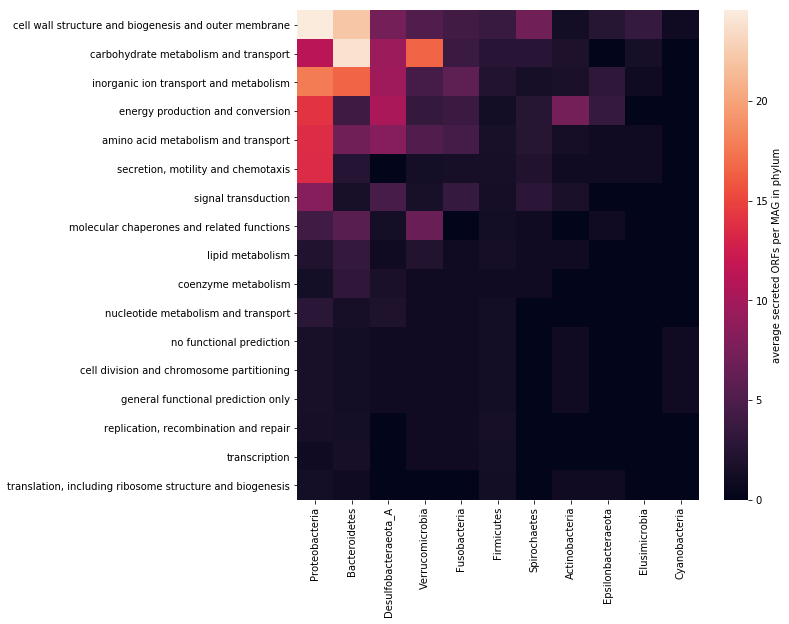

In [39]:

plt.subplots(figsize=(9,9))
sns.heatmap(phy_genome_numcog_average_df.drop('None', axis=0),
            #vmin=0, vmax=22,
            cbar_kws={'label':'average secreted ORFs per MAG in phylum'})

plt.rcParams['svg.fonttype'] = 'none'
plt.savefig('ipynb_out/Figures/Fig2_v1_COGs_phy_averagepermag_heatplot.svg',format='svg', bbox_inches="tight")

plt.show()

In [10]:
topec2descriptor = {'5.2.1.8': 'Peptidylprolyl isomerase',
 '3.5.1.28': 'N-acetylmuramoyl-L-alanine amidase',
 '3.4.16.4': 'Serine-type D-Ala-D-Ala carboxypeptidase',
 '3.2.1.4': 'Cellulase',
 '3.2.1.52': 'Beta-N-acetylhexosaminidase',
 '3.2.1.23': 'Beta-galactosidase',
 '3.2.1.51': 'Alpha-L-fucosidase',
 '3.2.1.78': 'Mannan endo-1,4-beta-mannosidase',
 '3.1.3.5': "5'-nucleotidase",
 '3.2.1.21': 'Beta-glucosidase',
 '2.7.1.21': 'Thymidine kinase',
 '2.7.1.180': 'FAD:protein FMN transferase',
 '1.14.14.47': 'Nitric-oxide synthase (flavodoxin)',
 '2.7.13.3': 'Histidine kinase',
 '3.2.1.1': 'Alpha-amylase',
 '3.6.1.45': 'UDP-sugar diphosphatase',
 '3.1.4.46': 'Glycerophosphodiester phosphodiesterase',
 '3.2.1.8': 'Endo-1,4-beta-xylanase',
 '3.2.1.20': 'Alpha-glucosidase',
 '1.3.5.4': 'Fumarate reductase (quinol)',
 '3.4.21.102': 'C-terminal processing peptidase',
 '3.1.3.1': 'Alkaline phosphatase',
 '3.2.1.22': 'Alpha-galactosidase',
 '3.4.21.107': 'Peptidase Do.',
 '3.1.3.6': "3'-nucleotidase",
'3.4.14.5': "Dipeptidyl-peptidase IV",
'3.1.1.53': "Sialate O-acetylesterase",
'3.4.22.40':"Bleomycin hydrolase",
'2.7.1.200':"Galactitol PTS permease",
'3.2.1.55':"Alpha-L-arabinofuranosidase",
'1.17.1.9':"Formate dehydrogenase"}


ec_counts_dict = count_ec_cats(eggnog_output)
ec_counts = pd.DataFrame(pd.Series(ec_counts_dict, name='counts')).sort_values('counts', ascending=False)['counts'][1:21]
eggnog_output.shape

#General top ECs in all secreted proteins from representative MAGs
topEC_phy_orfid_counts = pd.DataFrame()
#Make stacked bar plot of top EC phyla distribution

#Add taxonomy info
EC_annot_orfids = eggnog_output[['query','genome_id','EC']].dropna(subset=['EC'])
EC_annot_orfids_taxmeta = EC_annot_orfids.join(HGM_genomes.set_index('genome_id')[['repository','species_id']], 
                                               'genome_id').join(HGM_species.set_index('species_id')[['species_name',
                                                                                                      'gtdb_taxonomy']],'species_id')

for EC_query in ec_counts.index.tolist(): #list(topec2descriptor.keys()):
    EC_group_concat = pd.DataFrame()

    for name, group in EC_annot_orfids_taxmeta.groupby('EC'):
        if EC_query in name.split(','):
            EC_group_concat = EC_group_concat.append(group)

    EC_group_concat.drop_duplicates('query')
    #Count unique orfids in each phylum that have this EC annotation
    EC_orfids = EC_group_concat.drop_duplicates('query')
    EC_orfids['Phylum'] = [tax.split(';')[1].replace('p__','') for tax in EC_orfids['gtdb_taxonomy']]
    #EC_orfids['Phylum'].value_counts()
    topEC_phy_orfid_counts = topEC_phy_orfid_counts.append(pd.Series(EC_orfids['Phylum'].value_counts(), 
                                                                     name=topec2descriptor[EC_query]))
    
#If phylum has no annotations in any of the categories listed, add zeroes
for phy in list(phycoldict.keys()):
    if phy not in topEC_phy_orfid_counts.columns:
        topEC_phy_orfid_counts[phy] = 0

#Sort by phy with most ORFids total
topEC_phy_orfid_counts.fillna(0, inplace=True)
topEC_phy_orfid_counts = topEC_phy_orfid_counts.append(pd.Series(np.sum(topEC_phy_orfid_counts), name='Total')).sort_values(by=['Total'],axis=1, ascending=False).drop(['Total'], axis=0)

topEC_phy_orfid_counts = topEC_phy_orfid_counts.reindex(np.sum(topEC_phy_orfid_counts,axis=1).sort_values().index)



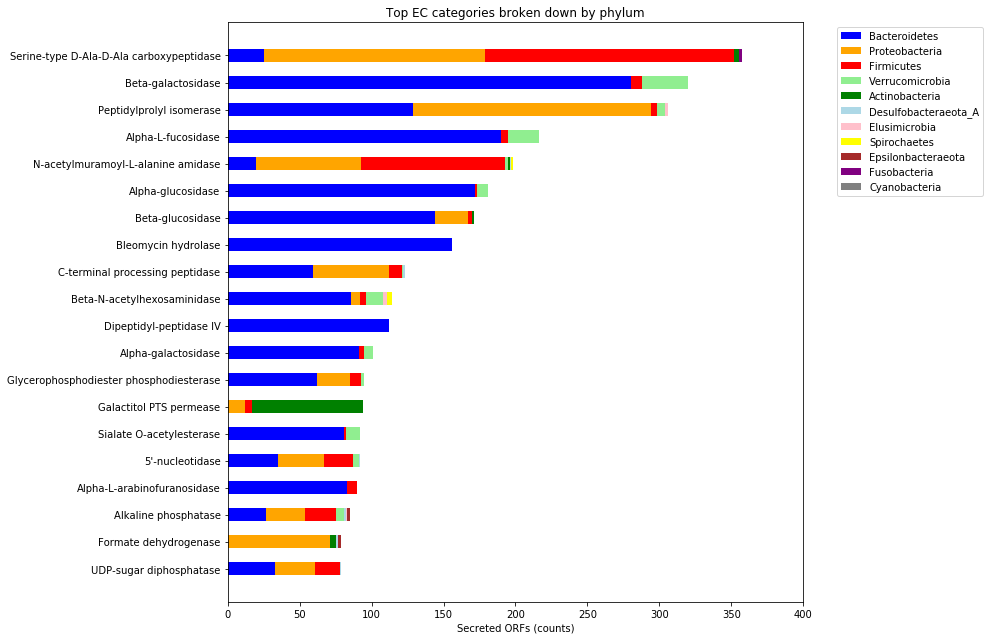

In [43]:
#Make stacked bar plot to show how much of the predicted metasecretome is from each phylum

labels = topEC_phy_orfid_counts.index.tolist()
height = 0.5

fig, ax = plt.subplots(figsize=(14,9))

left_prevphy = 0
for phy in topEC_phy_orfid_counts.columns:
    orfcounts = topEC_phy_orfid_counts[phy].tolist()
    if left_prevphy == 0:
        ax.barh(labels, orfcounts, height, label=phy, color=phycoldict[phy])
        left_prevphy = orfcounts
    else:
        ax.barh(labels, orfcounts, height, label=phy, left=left_prevphy, color=phycoldict[phy])
        left_prevphy = sum_lists_itemwise(left_prevphy,orfcounts)

ax.set_xlabel('Secreted ORFs (counts)')
ax.set_title('Top EC categories broken down by phylum')
ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
ax.set_xlim([0,400])
plt.rcParams['svg.fonttype'] = 'none'
plt.savefig('ipynb_out/Figures/Fig2_v1_topEC_phy_barplot.svg',
             format='svg', bbox_inches="tight", dpi=400)

plt.tight_layout()
plt.show()

In [11]:
maineccats_dict = {'1':'Oxidoreductases',
                '2': 'Transferases',
                '3':'Hydrolases',
                '4':'Lyases',
                '5':'Isomerases',
                '6': 'Ligases',
                'None':'None'}

def count_main_ec_cats(eggnog_output_sel):
    #Number of secreted proteins that fit in each COG category
    main_ec_counts_dict = dict()
    for cogcat in eggnog_output_sel['EC'].replace('-','None'):
        #if cogcat != 'None' and len(cogcat) > 0:
        #    list_of_cats = [char for char in cogcat]
        #else:
        #    list_of_cats = [cogcat]
        list_of_cats = cogcat.split(',')

        for cat in list_of_cats:
            maincat = cat.split('.')[0]
            maincat_word = maineccats_dict[str(maincat)]
            if maincat_word in main_ec_counts_dict.keys():
                main_ec_counts_dict[maincat_word] = main_ec_counts_dict[maincat_word] + 1
            else:
                main_ec_counts_dict[maincat_word] = 1
    return(main_ec_counts_dict)

In [12]:
eggnog_output_tax = eggnog_output.join(HGM_genomes.set_index('genome_id')[['repository','species_id']], 
                                               'genome_id').join(HGM_species.set_index('species_id')[['species_name',
                                                                                                      'gtdb_taxonomy']],'species_id')

eggnog_output_tax['Phylum'] = [tax.split(';')[1].replace('p__','') for tax in eggnog_output_tax['gtdb_taxonomy']]

main_ec_cats_phy_df = pd.DataFrame()
for name, group in eggnog_output_tax.groupby('Phylum'):

    if group['query'].unique().shape[0] > 500:
        #print(name)
        #print(count_main_ec_cats(group))
        main_ec_cats_phy_df = main_ec_cats_phy_df.append(pd.Series(count_main_ec_cats(group), name=name))
    
main_ec_cats_phy_df.fillna(0, inplace=True)

In [13]:
eggnog_output_tax_fillnanone = eggnog_output_tax.fillna('None')
different_ECs = list(set(ec_counts_dict.keys()) - {'None'})
#Count number of ORFs corresponding to each EC
EC_orfids_dict = dict()
for ECcat in different_ECs:
    #Make dict with list of orfids for each EC 
    EC_orfids_dict[ECcat] = eggnog_output_tax_fillnanone[[ECcat in fields.split(',') for fields in eggnog_output_tax_fillnanone['EC']]]['query'].unique().tolist()
    #print(ECcat)

#Make dataframe that has number of ORFids in each MAG in each EC category
ECcat_orfidcounts_bygenomeid = pd.DataFrame()
#Make dict with list of genome ids associated with each EC
for ECcat in EC_orfids_dict.keys():
    #Get genome ids
    genomeid_list = ['_'.join(orfid.split('_')[:2]) for orfid in EC_orfids_dict[ECcat]]
    #Count orfids in each MAG
    ECcat_orfidcounts_bygenomeid = ECcat_orfidcounts_bygenomeid.append(pd.Series(pd.Series(genomeid_list).value_counts(), name=ECcat))

In [14]:
#Make dict that is genomeid to OTU
genomeid2otu = dict()
#Make dict that is genomeid to gtdb taxonomy
genomeid2tax = dict()
#Make dict that is genomeid to family
genomeid2fam = dict()

for genomeid in ECcat_orfidcounts_bygenomeid.columns.unique():
    OTUlist = HGM_genomes[HGM_genomes['genome_id'] == genomeid]['species_id'].tolist()
    if len(OTUlist) == 1:
        genomeid2otu[genomeid] = OTUlist[0]
        taxlist = HGM_species[HGM_species['species_id'] == OTUlist[0]]['gtdb_taxonomy'].tolist()
        if len(taxlist) == 1:
            genomeid2tax[genomeid] = taxlist[0]
            if len(taxlist[0].split(';')) > 4:
                genomeid2fam[genomeid] = taxlist[0].split(';')[4]

In [15]:
ec_num_dict = {'1':'Oxidoreductases',
              '2':'Transferases',
              '3':'Hydrolases',
              '4':'Lyases',
              '5':'Isomerases',
              '6':'Ligases',
              '7':'Translocases'}


#Sum up # of secreted ORFs in each genomeid across main EC categories
sum_maincat = pd.DataFrame()

for maincat in ['1', '2', '3', '4', '5', '6']:
#maincat = '1'
    eccat_list = []
    for cat in ECcat_orfidcounts_bygenomeid.index.tolist():
        if cat.split('.')[0] == maincat:
            #print(cat)
            eccat_list.append(cat)
    sum_maincat = sum_maincat.append(pd.Series(np.sum(ECcat_orfidcounts_bygenomeid.loc[eccat_list].fillna(0), axis=0), name=ec_num_dict[maincat]))

#Group MAGs by family
sum_maincat_grouped = sum_maincat.append(pd.Series(genomeid2fam, name='Family')).transpose().groupby('Family')

#Average the sum of secreted orfs over each family of MAGs
avefamorfspermainEC = pd.DataFrame()
for name, group in sum_maincat_grouped:
    num_fam_genomeids = group.index.unique().shape[0]
    avefam = group.drop('Family', axis=1).fillna(0).sum()/num_fam_genomeids
    avefamorfspermainEC = avefamorfspermainEC.append(pd.Series(avefam, name=name))

In [17]:
! aws s3 cp s3://florencia-velez/working/20210519_signalp_analysis/ipynb_out/genomeid_fam_attr.tsv /home/ec2-user/20210519_signalp_analysis/ipynb_out/genomeid_fam_attr.tsv
! aws s3 cp s3://florencia-velez/working/20210519_signalp_analysis/20210609_gtdbtk_output/align/gtdbtk.bac120.user_msa.fasta.treefile /home/ec2-user/20210519_signalp_analysis/20210609_gtdbtk_output/align/gtdbtk.bac120.user_msa.fasta.treefile

download: s3://florencia-velez/working/20210519_signalp_analysis/ipynb_out/genomeid_fam_attr.tsv to ../20210519_signalp_analysis/ipynb_out/genomeid_fam_attr.tsv
download: s3://florencia-velez/working/20210519_signalp_analysis/20210609_gtdbtk_output/align/gtdbtk.bac120.user_msa.fasta.treefile to ../20210519_signalp_analysis/20210609_gtdbtk_output/align/gtdbtk.bac120.user_msa.fasta.treefile


In [18]:
mag_fam_attr = pd.read_csv('/home/ec2-user/20210519_signalp_analysis/ipynb_out/genomeid_fam_attr.tsv', sep='\t')
tree_nwk = pd.read_csv('/home/ec2-user/20210519_signalp_analysis/20210609_gtdbtk_output/align/gtdbtk.bac120.user_msa.fasta.treefile', sep=',', header=None).transpose()
#[string.replace('(','').replace(')','').split(':') 
mag_order = []
for string in tree_nwk[0]:
    for parsed in string.replace('(','').replace(')','').split(':'):
        if parsed in mag_fam_attr['genome_id'].tolist():
            mag_order.append(parsed)

reordered_index_list = []
for mag in mag_order:
    #print([mag])
    reordered_index_list.append("f__" + mag_fam_attr[mag_fam_attr['genome_id'] == mag]['family'].tolist()[0])
    #Sort index based on results for phylogenetic tree
avefamorfspermainEC.reindex(reordered_index_list)

,Hydrolases,Isomerases,Ligases,Lyases,Oxidoreductases,Transferases
f__Coriobacteriaceae,0.038462,0.000000,0.000000,0.000000,0.102564,0.987179
f__CAG-313,1.666667,0.000000,0.000000,0.000000,0.000000,0.000000
f__CAG-307,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000
f__CAG-433,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000
f__CAG-611,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000
f__CAG-302,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000
f__CAG-1000,0.600000,0.000000,0.000000,0.000000,0.000000,0.000000
f__Erysipelotrichaceae,0.250000,0.000000,0.000000,0.000000,0.166667,0.000000
f__Erysipelatoclostridiaceae,1.125000,0.000000,0.000000,0.000000,0.000000,1.750000
f__CAG-826,NaN,NaN,NaN,NaN,NaN,NaN


In [19]:
#col_dict = dict()
phylist = []

for fam in reordered_index_list:
    sel = HGM_species[HGM_species['gtdb_taxonomy'].str.contains(fam)]
    phy = set([tax.split(";")[1] for tax in  sel['gtdb_taxonomy']])
    if len(phy) == 1:
        phylist.append(list(phy)[0].replace('p__',''))
        #col_dict[fam] = colphy[phy]

In [20]:
np.max(np.max(avefamorfspermainEC))

27.26086956521739

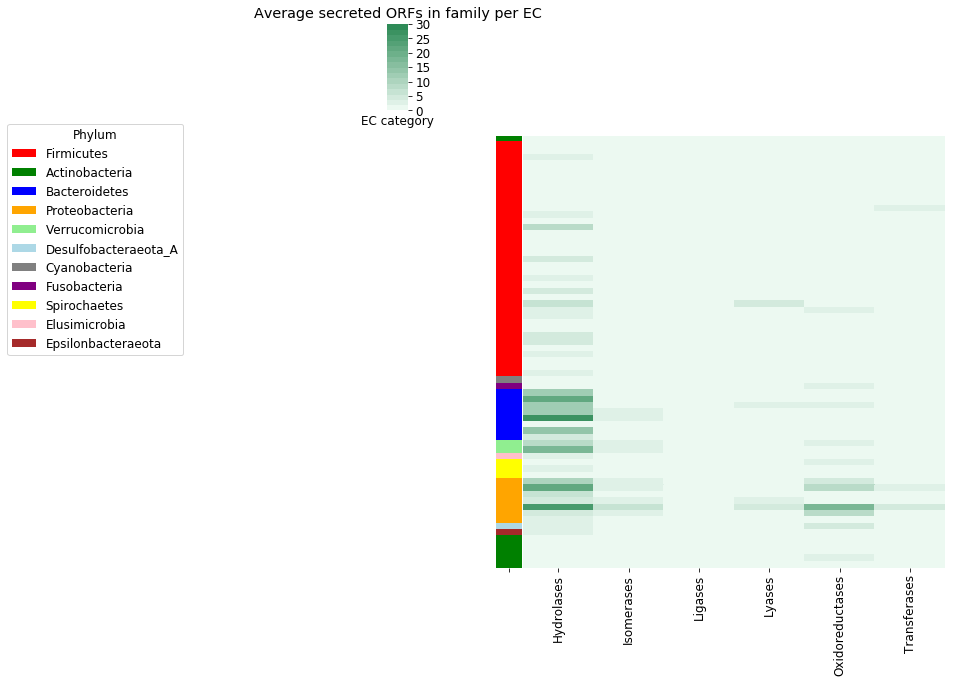

In [67]:
plt.rcParams.update({'font.size': 12})
#plt.figure(figsize=(30,30))
num_ave = 16
#sns.light_palette("seagreen", as_cmap=True)
#ax = sns.clustermap(ec_mapstats_reorderlist[0].reset_index(drop=True))
#ax = sns.heatmap(avefamorfspermainEC, cmap='rocket_r', xticklabels=True)
#sns.light_palette("seagreen", as_cmap=True)
#Sort index based on results for phylogenetic tree
#avefamorfspermainEC.reindex(reordered_index_list)
row_colors = pd.Series(phylist).map(phycoldict)
ax = sns.clustermap(avefamorfspermainEC.reindex(reordered_index_list).fillna(0).reset_index(drop=True), 
                 cmap = sns.light_palette("seagreen", n_colors=num_ave), 
                 row_colors = row_colors,
                    vmax=30,
                     row_cluster=False, col_cluster=False,
                 xticklabels=True,
                    yticklabels=False)
#ECcat_orfidcounts_bygenomeid.fillna(0)

handles = [mpatches.Patch(facecolor=phycoldict[name]) for name in phycoldict]
plt.legend(handles, phycoldict, title='Phylum',
          bbox_to_anchor=(-0.15, 0.75), bbox_transform=plt.gcf().transFigure)#, loc='upper right')

plt.xlabel('EC category')
plt.title('Average secreted ORFs in family per EC')

plt.savefig('ipynb_out/Figures/Fig2_v1_mainec_fam_avecount_heatplot.png',format='png', bbox_inches="tight")
plt.savefig('ipynb_out/Figures/Fig2_v1_mainec_fam_avecount_heatplot.svg',format='svg', bbox_inches="tight")


In [ ]:
maineccats_dict = {'1':'Oxidoreductases',
                '2': 'Transferases',
                '3':'Hydrolases',
                '4':'Lyases',
                '5':'Isomerases',
                '6': 'Ligases',
                'None':'None'}

def count_main_ec_cats(eggnog_output_sel):
    #Number of secreted proteins that fit in each COG category
    main_ec_counts_dict = dict()
    for cogcat in eggnog_output_sel['EC'].replace('-','None'):
        #if cogcat != 'None' and len(cogcat) > 0:
        #    list_of_cats = [char for char in cogcat]
        #else:
        #    list_of_cats = [cogcat]
        list_of_cats = cogcat.split(',')

        for cat in list_of_cats:
            maincat = cat.split('.')[0]
            maincat_word = maineccats_dict[str(maincat)]
            if maincat_word in main_ec_counts_dict.keys():
                main_ec_counts_dict[maincat_word] = main_ec_counts_dict[maincat_word] + 1
            else:
                main_ec_counts_dict[maincat_word] = 1
    return(main_ec_counts_dict)

In [73]:
def get_oxidoreductase_annotations():
    all_annotations = eggnog_output_tax
    all_annotations['EC'].replace('-', np.nan, inplace=True)
    all_annotations.dropna(subset=['EC'], inplace=True)
    
    oxidoreductase_ec_annots = []
    for eccat in all_annotations['EC']:
        list_of_cats = eccat.split(',')
        for cat in list_of_cats:
                maincat = cat.split('.')[0]
                if maincat == '1':
                    oxidoreductase_ec_annots.append(eccat)
    
    oxidoreductase_annotations = all_annotations[all_annotations['EC'].isin(list(set(oxidoreductase_ec_annots)))]
    return(oxidoreductase_annotations)

In [84]:
get_oxidoreductase_annotations()

,query,seed_ortholog,evalue,score,eggNOG_OGs,max_annot_lvl,COG_category,Description,Preferred_name,GOs,EC,KEGG_ko,KEGG_Pathway,KEGG_Module,KEGG_Reaction,KEGG_rclass,BRITE,KEGG_TC,CAZy,BiGG_Reaction,PFAMs,genome_id,repository,species_id,species_name,gtdb_taxonomy,Phylum
26,ERS235602_37_k99_15243_51,754331.AEME01000001_gene962,2.760000e-141,398.0,"COG0243@1|root,COG0243@2|Bacteria,1MWPS@1224|P...",1236|Gammaproteobacteria,C,Molybdopterin oxidoreductase Fe4S4 domain,fdoG,-,1.17.1.9,ko:K00123,"ko00630,ko00680,ko01100,ko01120,ko01200,map006...",-,R00519,RC02796,"ko00000,ko00001,ko01000",-,-,-,"Molybdop_Fe4S4,Molybdopterin",ERS235602_37,HGM,OTU-20441,Escherichia coli,d__Bacteria;p__Proteobacteria;c__Gammaproteoba...,Proteobacteria
27,ERS608504_29_k95_82944_47,754331.AEME01000001_gene962,2.760000e-141,398.0,"COG0243@1|root,COG0243@2|Bacteria,1MWPS@1224|P...",1236|Gammaproteobacteria,C,Molybdopterin oxidoreductase Fe4S4 domain,fdoG,-,1.17.1.9,ko:K00123,"ko00630,ko00680,ko01100,ko01120,ko01200,map006...",-,R00519,RC02796,"ko00000,ko00001,ko01000",-,-,-,"Molybdop_Fe4S4,Molybdopterin",ERS608504_29,HGM,OTU-20442,Escherichia coli,d__Bacteria;p__Proteobacteria;c__Gammaproteoba...,Proteobacteria
28,ERS473036_15_k99_16601_2,1399774.JDWH01000014_gene3541,2.760000e-141,398.0,"COG0243@1|root,COG0243@2|Bacteria,1MWPS@1224|P...",1236|Gammaproteobacteria,C,PFAM Molybdopterin oxidoreductase Fe4S4 region,fdoG,-,"1.17.1.9,1.17.5.3","ko:K00123,ko:K08348","ko00630,ko00680,ko01100,ko01120,ko01200,ko0202...",-,R00519,RC02796,"ko00000,ko00001,ko01000",5.A.3.2,-,-,"Molybdop_Fe4S4,Molybdopterin",ERS473036_15,HGM,OTU-20410,Enterobacter cloacae,d__Bacteria;p__Proteobacteria;c__Gammaproteoba...,Proteobacteria
29,SRS372942_3_k119_2904_75,1080067.BAZH01000038_gene3739,1.870000e-139,394.0,"COG0243@1|root,COG0243@2|Bacteria,1MWPS@1224|P...",1236|Gammaproteobacteria,C,Molybdopterin oxidoreductase Fe4S4 domain,fdoG,-,1.17.1.9,ko:K00123,"ko00630,ko00680,ko01100,ko01120,ko01200,map006...",-,R00519,RC02796,"ko00000,ko00001,ko01000",-,-,-,"Molybdop_Fe4S4,Molybdopterin",SRS372942_3,HGM,OTU-20374,Citrobacter koseri,d__Bacteria;p__Proteobacteria;c__Gammaproteoba...,Proteobacteria
30,SRS476609_15_k119_51163_99,90371.CY43_21105,1.940000e-141,399.0,"COG0243@1|root,COG0243@2|Bacteria,1MWPS@1224|P...",1236|Gammaproteobacteria,C,Molybdopterin oxidoreductase Fe4S4 domain,fdoG,-,"1.17.1.9,1.17.5.3","ko:K00123,ko:K08348","ko00630,ko00680,ko01100,ko01120,ko01200,ko0202...",-,R00519,RC02796,"ko00000,ko00001,ko01000",5.A.3.2,-,-,"Molybdop_Fe4S4,Molybdopterin",SRS476609_15,HGM,OTU-20658,Salmonella enterica,d__Bacteria;p__Proteobacteria;c__Gammaproteoba...,Proteobacteria
31,ERS537201_56_k99_146437_78,754331.AEME01000001_gene962,2.760000e-141,398.0,"COG0243@1|root,COG0243@2|Bacteria,1MWPS@1224|P...",1236|Gammaproteobacteria,C,Molybdopterin oxidoreductase Fe4S4 domain,fdoG,-,1.17.1.9,ko:K00123,"ko00630,ko00680,ko01100,ko01120,ko01200,map006...",-,R00519,RC02796,"ko00000,ko00001,ko01000",-,-,-,"Molybdop_Fe4S4,Molybdopterin",ERS537201_56,HGM,OTU-20438,Escherichia coli,d__Bacteria;p__Proteobacteria;c__Gammaproteoba...,Proteobacteria
32,ERS473196_2_k99_5793_19,571.MC52_08370,1.120000e-140,397.0,"COG0243@1|root,COG0243@2|Bacteria,1MWPS@1224|P...",1236|Gammaproteobacteria,C,Sulfate ABC transporter substrate-binding protein,fdoG,-,"1.17.1.9,1.17.5.3","ko:K00123,ko:K08348","ko00630,ko00680,ko01100,ko01120,ko01200,ko0202...",-,R00519,RC02796,"ko00000,ko00001,ko01000",5.A.3.2,-,-,"Molybdop_Fe4S4,Molybdopterin",ERS473196_2,HGM,OTU-20495,Klebsiella oxytoca,d__Bacteria;p__Proteobacteria;c__Gammaproteoba...,Proteobacteria
33,SRS371548_7_k119_202_28,1399774.JDWH01000014_gene3541,1.940000e-141,399.0,"COG0243@1|root,COG0243@2|Bacteria,1MWPS@1224|P...",1236|Gammaproteobacteria,C,PFAM Molybdopterin oxidoreductase Fe4S4 region,fdoG,-,"1.17.1.9,1.17.5.3","ko:K00123,ko:K08348","ko00630,ko00680,ko01100,ko01120,ko01200,ko0202...",-,R00519,RC02796,"ko00000,ko00001,ko01000",5.A.3.2,-,-,"Molybdop_Fe4S4,Molybdopterin

In [82]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
get_oxidoreductase_annotations().COG_category.value_counts()

C     373
M      56
O      54
Q      36
P      32
I      13
S       9
E       8
-       3
CO      2
G       2
H       1
Name: COG_category, dtype: int64

In [83]:
COG2descriptor

{'J': 'translation, including ribosome structure and biogenesis',
 'L': 'replication, recombination and repair',
 'K': 'transcription',
 'O': 'molecular chaperones and related functions',
 'M': 'cell wall structure and biogenesis and outer membrane',
 'N': 'secretion, motility and chemotaxis',
 'T': 'signal transduction',
 'P': 'inorganic ion transport and metabolism',
 'C': 'energy production and conversion',
 'G': 'carbohydrate metabolism and transport',
 'E': 'amino acid metabolism and transport',
 'F': 'nucleotide metabolism and transport',
 'H': 'coenzyme metabolism',
 'I': 'lipid metabolism',
 'D': 'cell division and chromosome partitioning',
 'R': 'general functional prediction only',
 'S': 'no functional prediction',
 'None': 'None'}

In [78]:
get_oxidoreductase_annotations().Description.value_counts()

Molybdopterin oxidoreductase Fe4S4 domain                                                                                                                                                                48
Belongs to the prokaryotic molybdopterin-containing oxidoreductase family                                                                                                                                46
Destroys radicals which are normally produced within the cells and which are toxic to biological systems                                                                                                 36
Catalyzes the reduction of nitrite to ammonia, consuming six electrons in the process                                                                                                                    26
Has an important function as a repair enzyme for proteins that have been inactivated by oxidation. Catalyzes the reversible oxidation-reduction of methionine sulfoxide in proteins to m

In [85]:
get_oxidoreductase_annotations().Preferred_name.value_counts()[:20]
#.Description.value_counts()

-       180
fdnG     41
fdoG     29
sodC     28
nrfA     26
msrA     26
dmsA     25
degP     23
mqo      20
cueO     19
torA     18
ugd      18
sdhA     14
bsaA     11
nirK      9
ccp       7
torZ      7
ynfE      7
gpsA      6
ttrA      6
Name: Preferred_name, dtype: int64